In [241]:
import os
import sys
from pathlib import Path

import anndata as ad
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.pyplot import rc_context
from skimage import exposure, io
from skimage.util import img_as_ubyte
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm, trange

sc.settings.verbosity = 3

In [242]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [243]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import scanorama
import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [244]:
experiment = "endometrium"
cores = ["L128"]
datasets = ["L11_2", "L11_3"]+[core + f"_{i}" for core in cores for i in range(1, 4)]

# Load data

In [245]:
def read_props(dataset):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{dataset}.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [246]:
adatas = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(
            "_".join([experiment, dataset])
        )
    except:
        continue
    df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
        df_morph["area"], axis=0
    )
    pseudo_count=1
    data_all = df_intensity_TS.iloc[:, 1:].values
    data_all_norm = (data_all+pseudo_count)/(np.percentile(data_all,50,axis=1,keepdims=True)+pseudo_count)
    data_all_norm = MinMaxScaler().fit_transform(data_all_norm)
    df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    df = df_intensity_IMC.merge(df_intensity_TS, on="Id")
    df.set_index("Id", inplace=True)

    adata = sc.AnnData(df.values, dtype=df.values.dtype)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset.split("_")[0]
    adata.obs["Core"] = dataset
    adata.obsm["spatial"] = df_morph[["centroid-1", "centroid-0"]].to_numpy()
    adatas.append(adata)

adata = ad.concat(adatas, join="inner")

C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [247]:
IMC_markers = df_intensity_IMC.columns[1:]
SIMS_masses = df_intensity_TS.columns[1:]

In [248]:
IMC_markers

Index(['CD3', 'CD45RA', 'CD45RO', 'CD8a', 'DNA1', 'DNA2', 'Ecaderin',
       'PanKeratin', 'SMA', 'Vimentin'],
      dtype='object')

In [249]:
IMC_markers = IMC_markers.drop(["DNA1", "DNA2", 'CD45RO', 'CD45RA'])

In [250]:
df_intensity_IMC

Id        CD3     CD45RA     CD45RO      CD8a       DNA1       DNA2  \
0      1   0.000000  21.384615  13.230769  0.128205  19.435897  19.551282   
1      2   0.000000  27.085714  13.457143  6.457143  17.628571  19.971429   
2      3   0.000000  30.467742  30.548387  0.209677  50.032258  51.306452   
3      4   0.000000  25.041322  10.495868  0.000000  12.768595  14.785124   
4      5   0.000000  24.118644  11.084746  0.000000  24.915254  25.677966   
..   ...        ...        ...        ...       ...        ...        ...   
896  897   0.000000  30.767442  44.209302  6.883721  49.720930  50.604651   
897  898  37.967213  26.475410  46.786885  1.688525  28.901639  27.327869   
898  899   0.000000  20.904762  10.095238  0.000000  29.285714  27.000000   
899  900   0.000000  42.323529  14.882353  2.382353  31.617647  34.382353   
900  901   0.000000  26.080000  13.980000  6.940000  19.200000  19.120000   

      Ecaderin  PanKeratin        SMA   Vimentin  
0    13.858974    6.217949   4.256410  12.730769  
1     8.342857    2.742857   5.314286  17.971429  
2    20.161290   15.354839  19.822581  23.435484  
3    17.528926    0.000000   3.611570   2.181818  
4    10.423729    2.406780   5.372881  10.525424  
..         ...         ...        ...        ...  
896  35.720930   38.767442  47.581395  13.720930  
897  20.278689    0.000000   1.836066  13.573770  
898  18.523810    0.000000   4.119048   6.142857  
899  29.558824   29.088235  38.852941   9.500000  
900  10.160000    0.000000   1.420000   6.040000  

[901 rows x 11 columns]

# IMC cell phenotype

## Data ingegration

In [251]:
adata_IMC = adata[:, IMC_markers]

In [252]:
alldata = {}

for batch in adata_IMC.obs["Dataset"].unique():
    adata_subset = adata_IMC[
        adata_IMC.obs["Dataset"] == batch,
    ]
    sc.pp.scale(adata_subset, max_value=4)
    alldata[batch] = adata_subset

# convert to list of AnnData objects
adatas = list(alldata.values())

# run scanorama.integrate
adatas_cor = scanorama.correct_scanpy(adatas, return_dimred=True, return_dense=True, dimred=10)

# make into one matrix.
adata_IMC = ad.concat(adatas_cor)

C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\preprocessing\_simple.py:843: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-package

Found 6 genes among all datasets
[[0.         0.89420655]
 [0.         0.        ]]
Processing datasets (0, 1)


C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanorama\scanorama.py:237: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(datasets[i])
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [253]:
sc.pp.neighbors(adata_IMC, use_rep="X_scanorama")
sc.tl.umap(adata_IMC)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


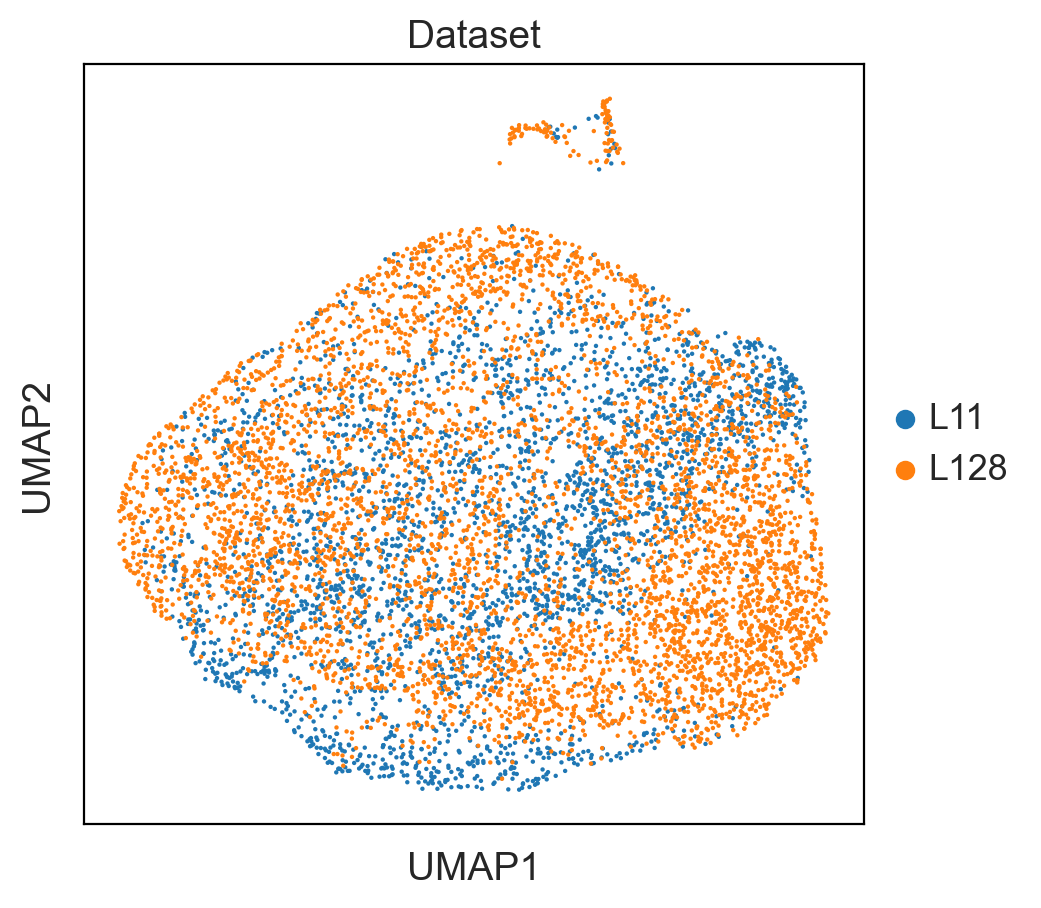

In [254]:
sc.set_figure_params(format="png")

with rc_context({"figure.figsize": (5, 5), "figure.dpi": 100}):
    fig = sc.pl.umap(adata_IMC, color=["Dataset"], size=10)

C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


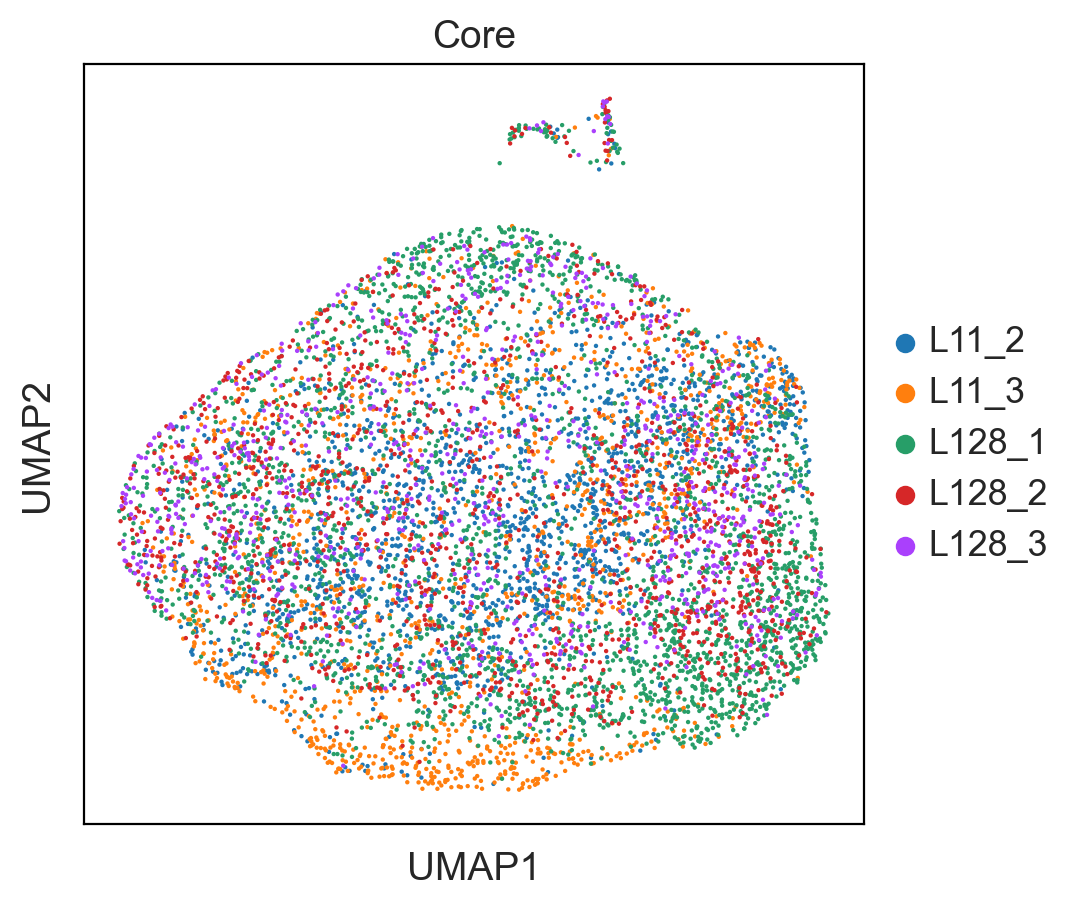

In [255]:
sc.set_figure_params(format="png")

with rc_context({"figure.figsize": (5, 5), "figure.dpi": 100}):
    fig = sc.pl.umap(adata_IMC, color=["Core"], size=10)

In [256]:
# sc.tl.tsne(adata_IMC, use_rep="X_scanorama")

In [257]:
# sc.set_figure_params(format="png")

# with rc_context({"figure.figsize": (7, 7), "figure.dpi": 100}):
#     fig = sc.pl.tsne(adata_IMC, color=["Dataset"], size=10)

L11_2


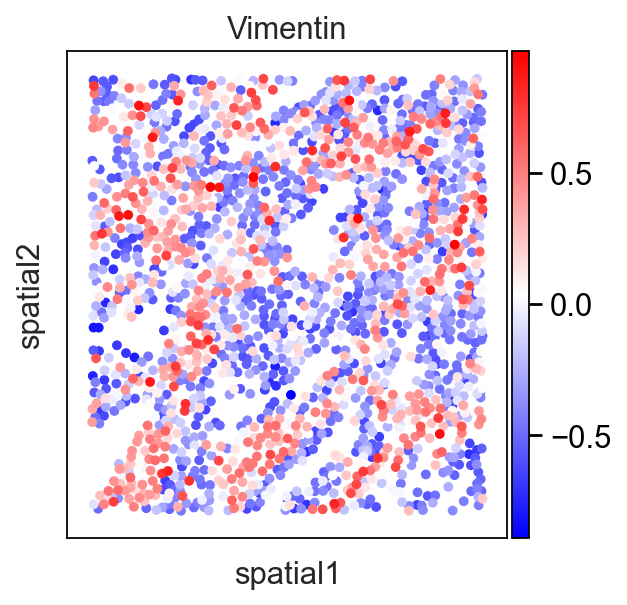

L11_3


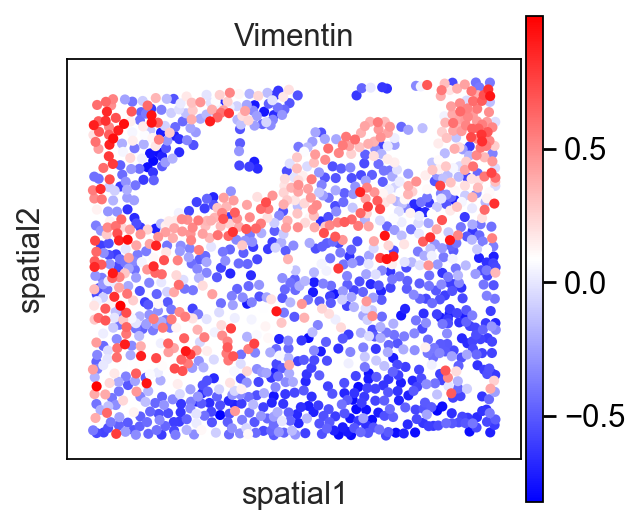

L128_1


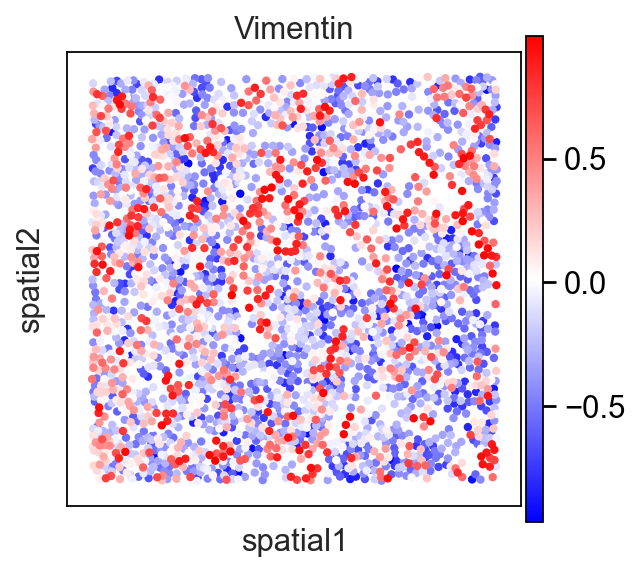

L128_2


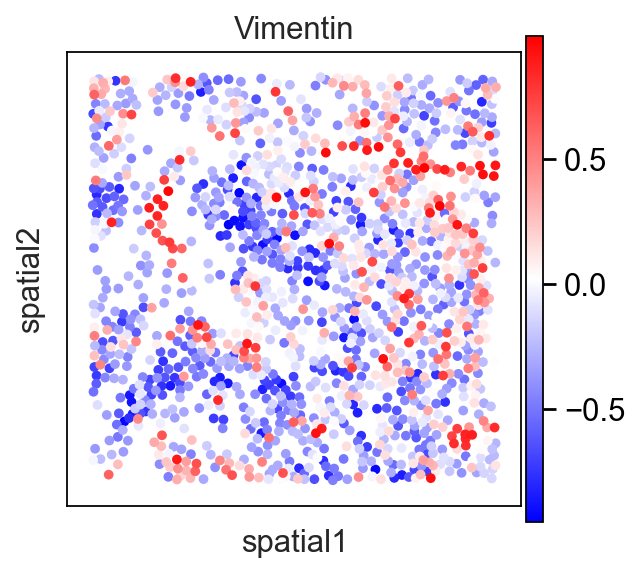

L128_3


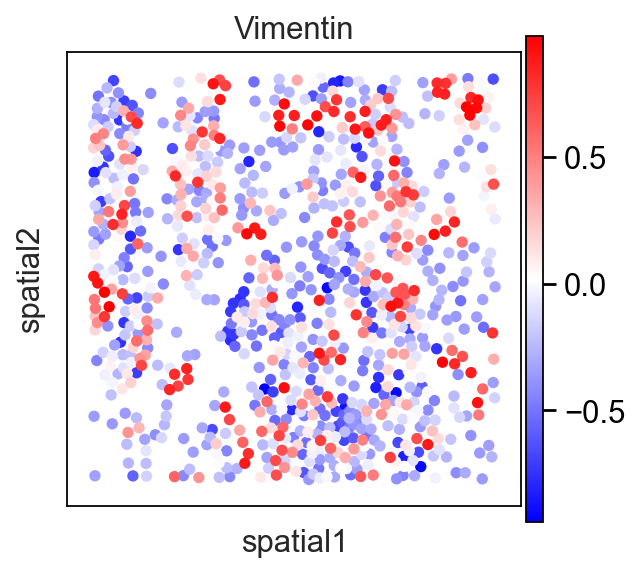

In [258]:
for dataset in datasets:
    print(dataset)
    adata_subset = adata_IMC[adata_IMC.obs.Core == dataset, :]
    sc.pl.spatial(adata_subset, color='Vimentin', spot_size=10, cmap='bwr')

## Clustering

In [269]:
sc.pp.neighbors(adata_IMC, random_state=0)
sc.tl.leiden(adata_IMC, resolution=0.11, random_state=0)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


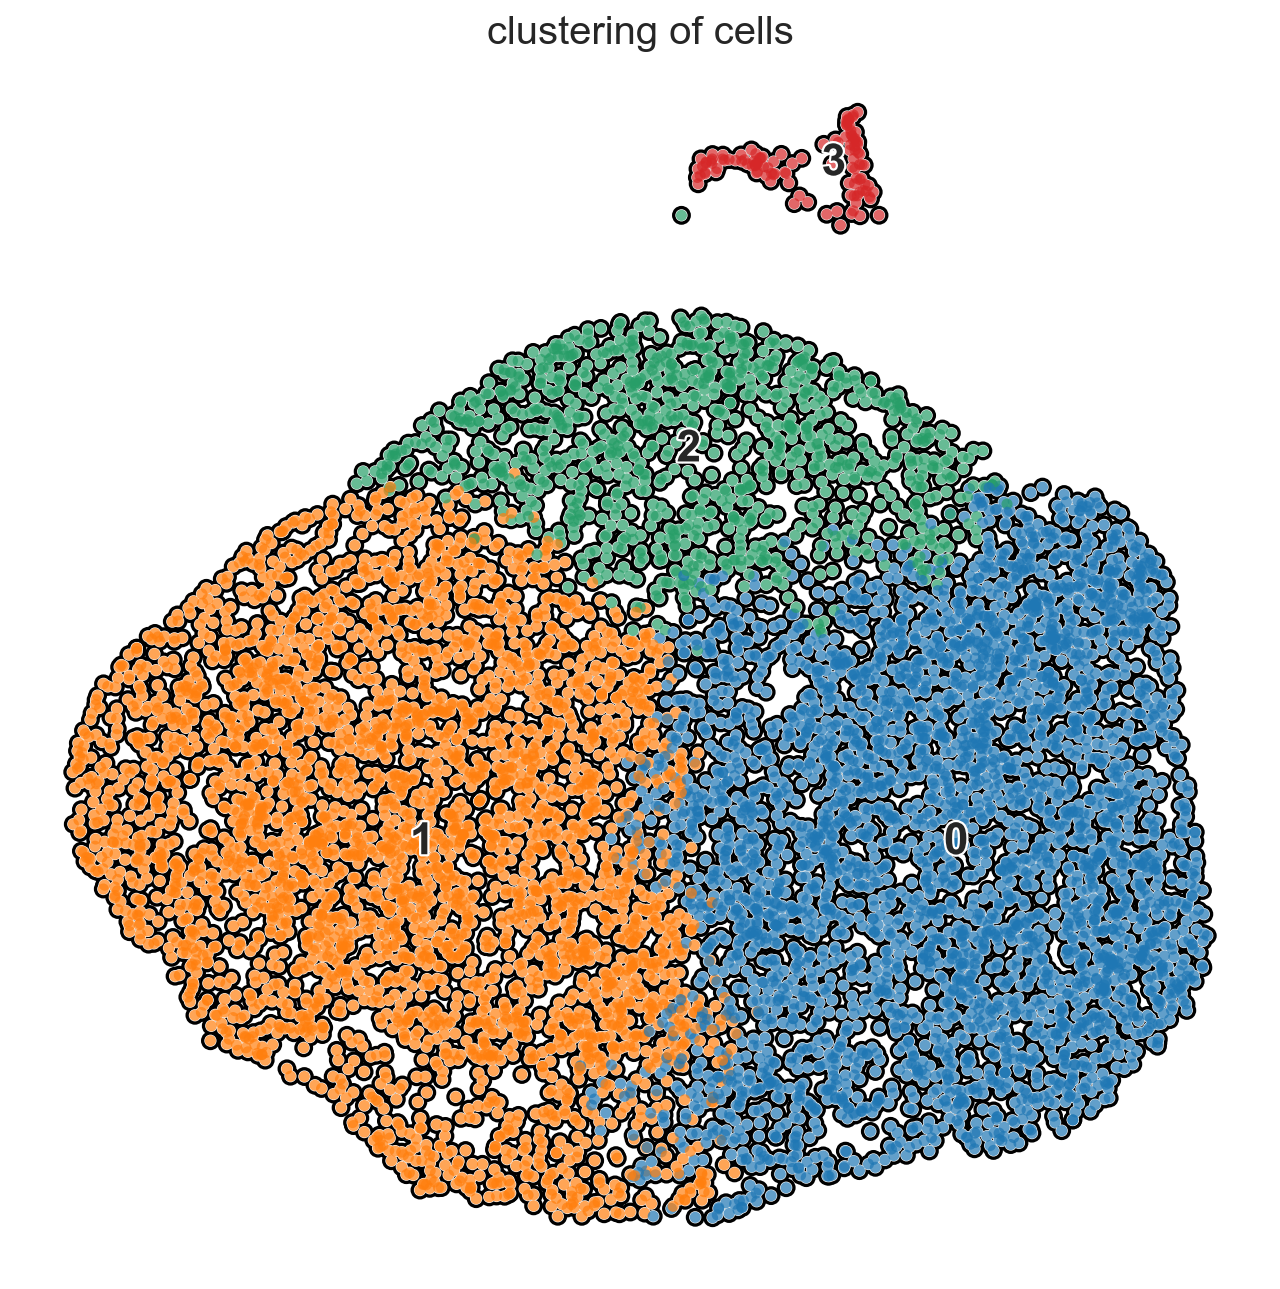

In [270]:
with rc_context({"figure.figsize": (10, 10)}):
    sc.pl.umap(
        adata_IMC,
        color=["leiden"],
        size=100,
        legend_loc="on data",
        add_outline=True,
        legend_fontsize=20,
        legend_fontoutline=2,
        frameon=False,
        title="clustering of cells",
    )

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden']`


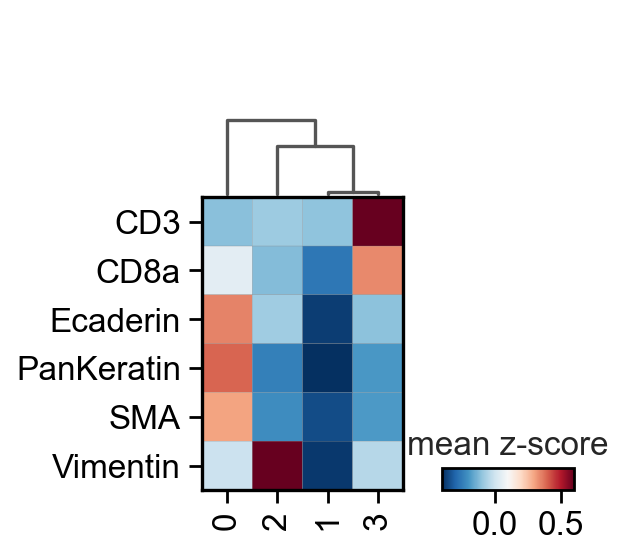

In [271]:
sc.tl.dendrogram(adata_IMC, groupby="leiden")

sns.set_context("notebook", font_scale=1.5)
sc.pl.matrixplot(
    adata_IMC,
    adata_IMC.var_names.tolist(),
    "leiden",
    dendrogram=True,
    colorbar_title="mean z-score",
    cmap="RdBu_r",
    swap_axes=True,
    vmax=0.6
)

C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\plotting\_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


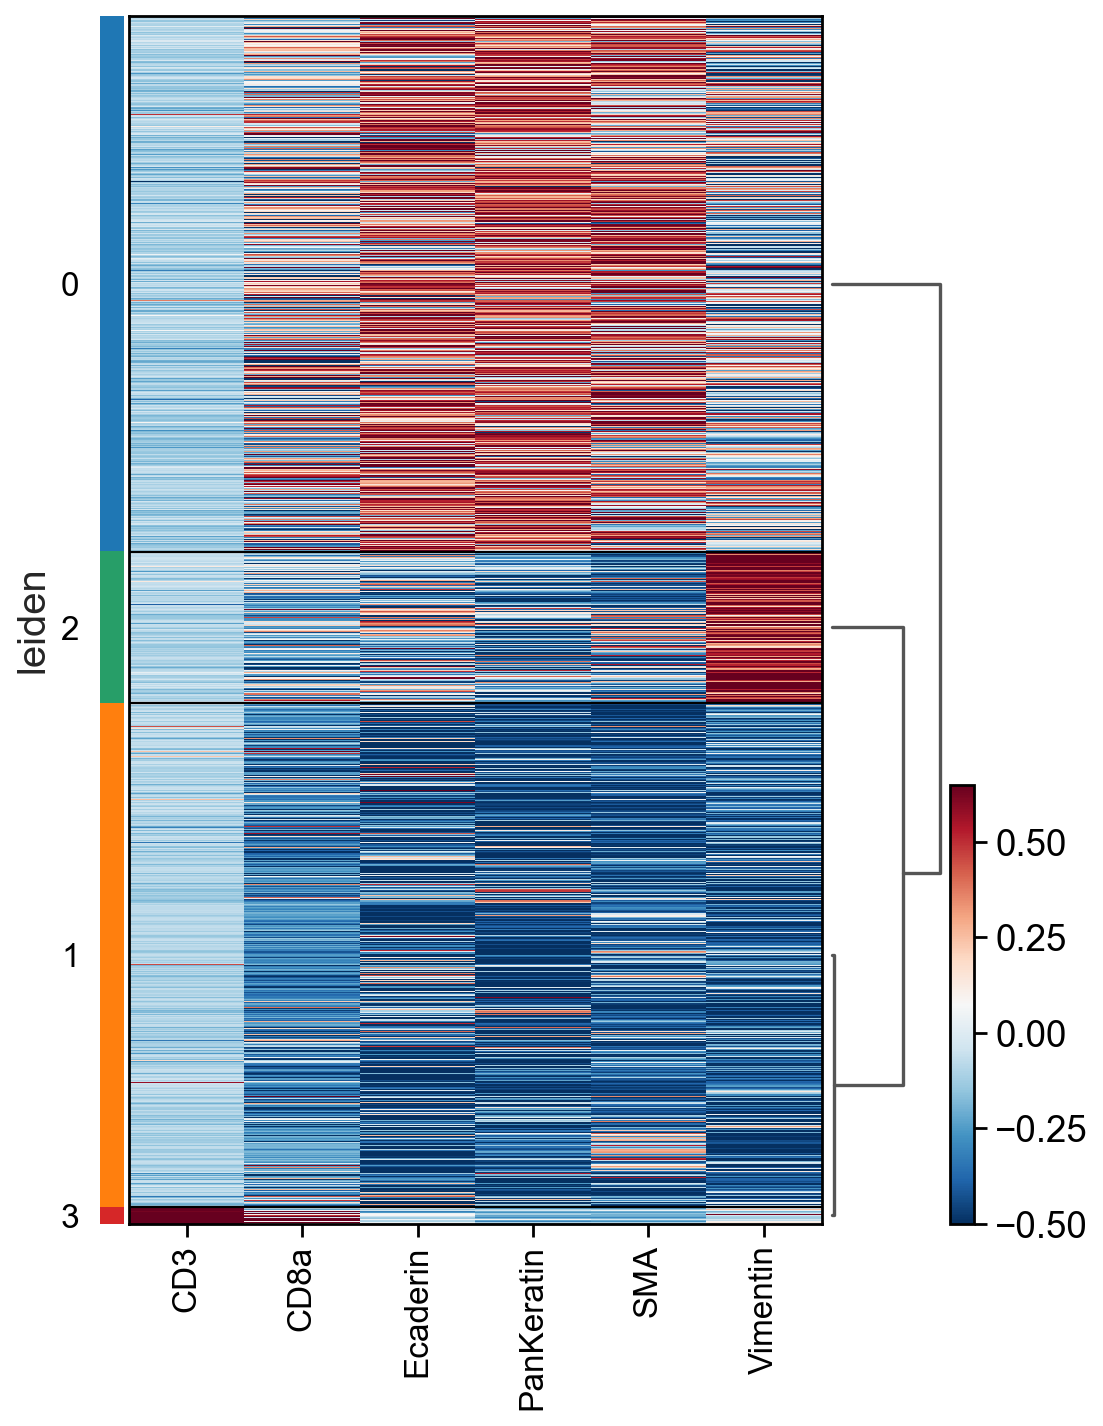

In [272]:
sc.pl.heatmap(
    adata_IMC,
    adata_IMC.var_names.tolist(),
    "leiden",
    dendrogram=True,
    cmap="RdBu_r",
    figsize=(7, 10),
    vmin=-0.5,
    vmax=0.65
)

In [273]:
cluster_label_order = adata_IMC.uns['dendrogram_leiden']['categories_ordered']

In [274]:
import matplotlib 

colors = adata_IMC.uns["leiden_colors"]
labels = adata_IMC.obs.leiden.cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

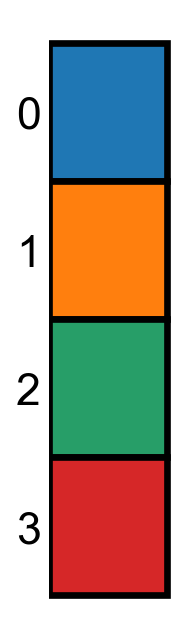

In [275]:
# legend
fig, ax = plt.subplots(figsize=(1,5))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=np.array(list(colors_rgb_dict.values()))/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), colors_rgb_dict.keys(), rotation=0, size=20)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


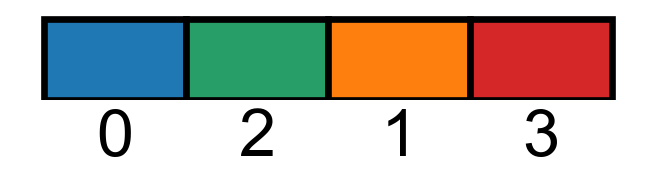

In [276]:
# legend
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

fig, ax = plt.subplots(figsize=(5,0.7))
ax.bar(x=cluster_label_order, 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.xticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=30)
_ = plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.grid(False)


In [277]:
df = pd.DataFrame(adata_IMC.X, columns=adata_IMC.var_names)
df['ROI'] = adata_IMC.obs.Dataset.tolist()
df['Clusters'] = adata_IMC.obs.leiden.tolist()

In [278]:
df_count = (
    df.groupby(['ROI', 'Clusters'])
    .size()
    .div(
        df.groupby(['ROI'])['Clusters'].size()
    )
    .reset_index(name = 'Density')
)

<AxesSubplot: xlabel='Clusters', ylabel='Density'>

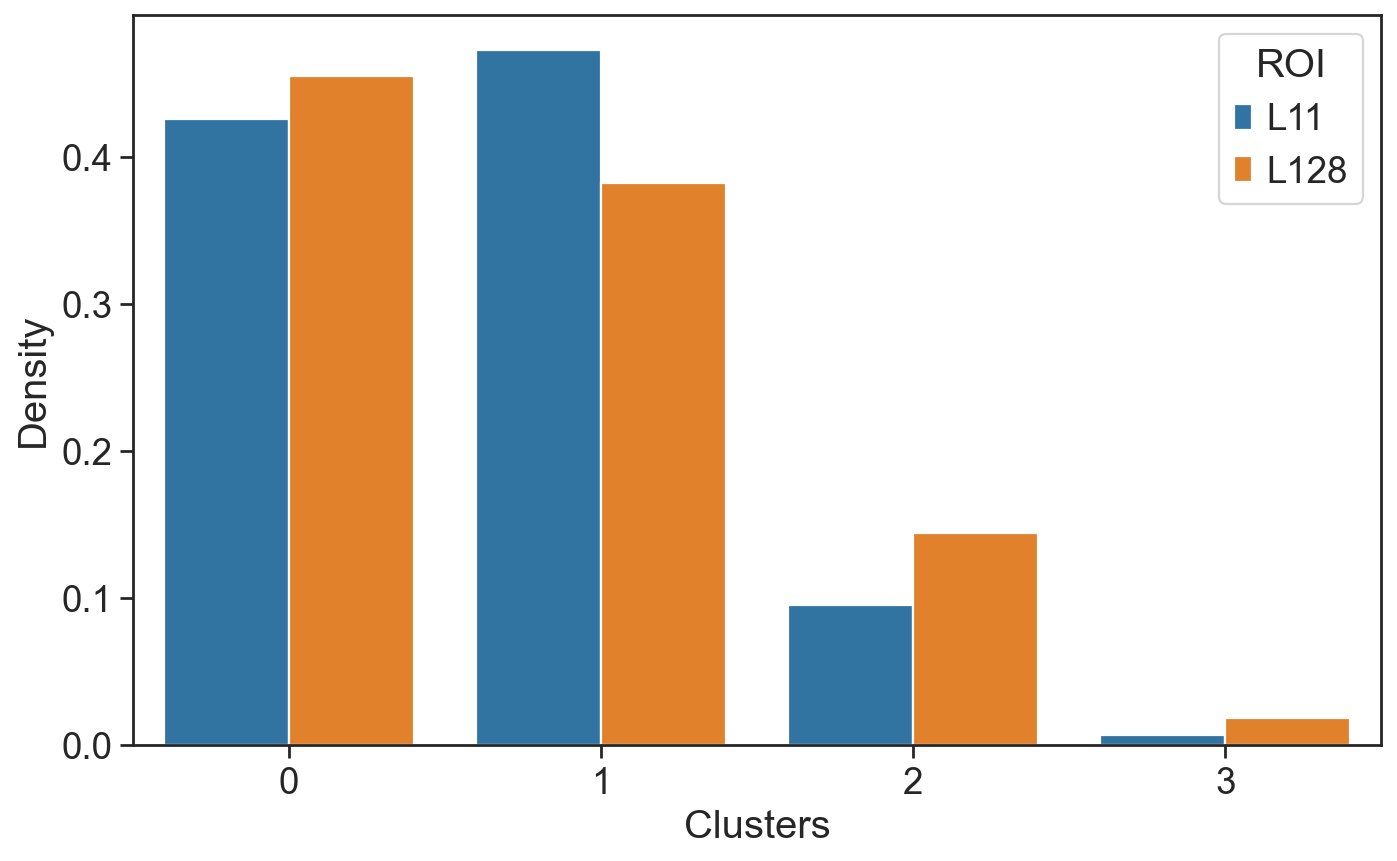

In [279]:
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df_count, x='Clusters', y='Density', hue='ROI', ax=ax)

## Spatial projection

In [280]:
from typing import List
import matplotlib
import skimage
from skimage import measure


def get_masks(mask_folder, dataset):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name and dataset in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    for i, cells in tqdm(label2cell.items(), total=len(label2cell)):
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]

    return img


def get_contour(mask: np.ndarray) -> List[List[float]]:
    """
    Get contours of mask
    """
    contours = []
    for i in sorted(np.unique(mask)):
        if i == 0:
            continue
        contours.append(measure.find_contours(mask == i, 0.8)[0])

    return contours

In [281]:
masks = get_masks(data_dir / "masks", f"{experiment}")

In [282]:
colors = adata_IMC.uns["leiden_colors"]
labels = np.unique(adata_IMC.obs.leiden.tolist())

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

L11_2


  0%|          | 0/4 [00:00<?, ?it/s]

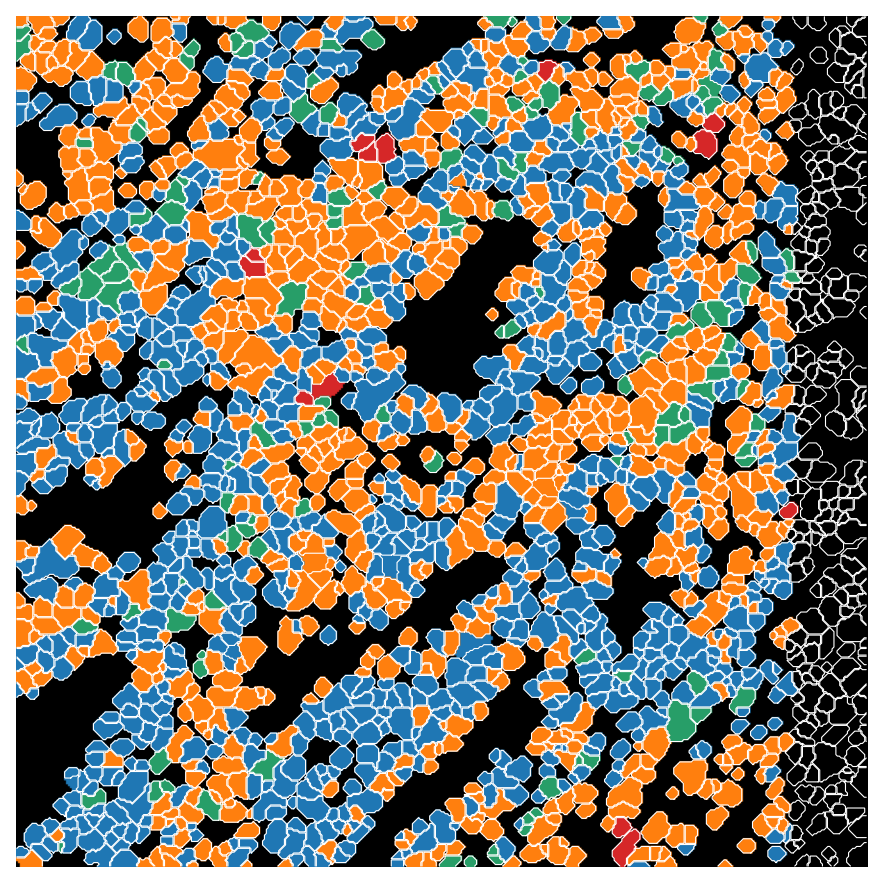

L11_3


  0%|          | 0/4 [00:00<?, ?it/s]

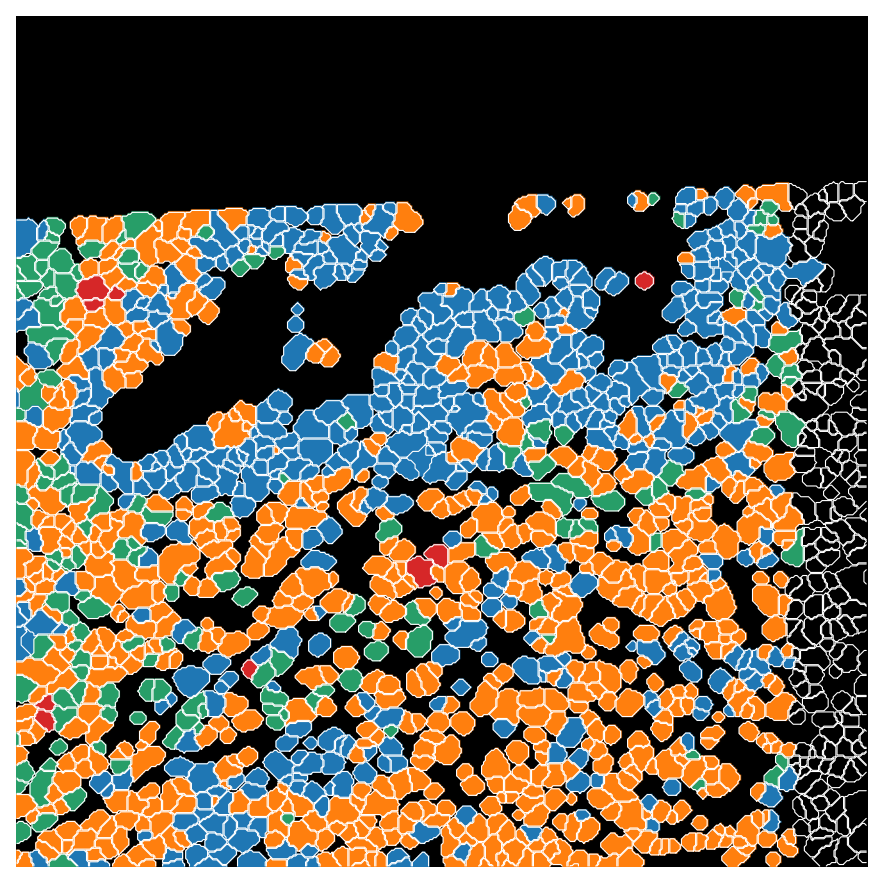

L128_1


  0%|          | 0/4 [00:00<?, ?it/s]

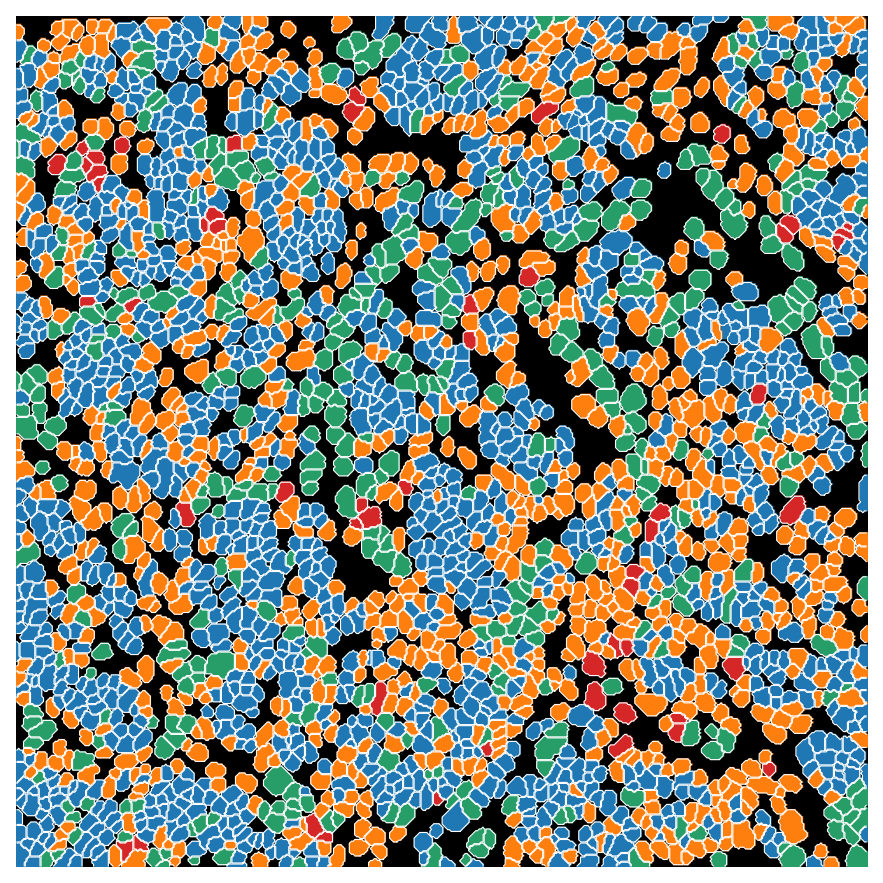

L128_2


  0%|          | 0/4 [00:00<?, ?it/s]

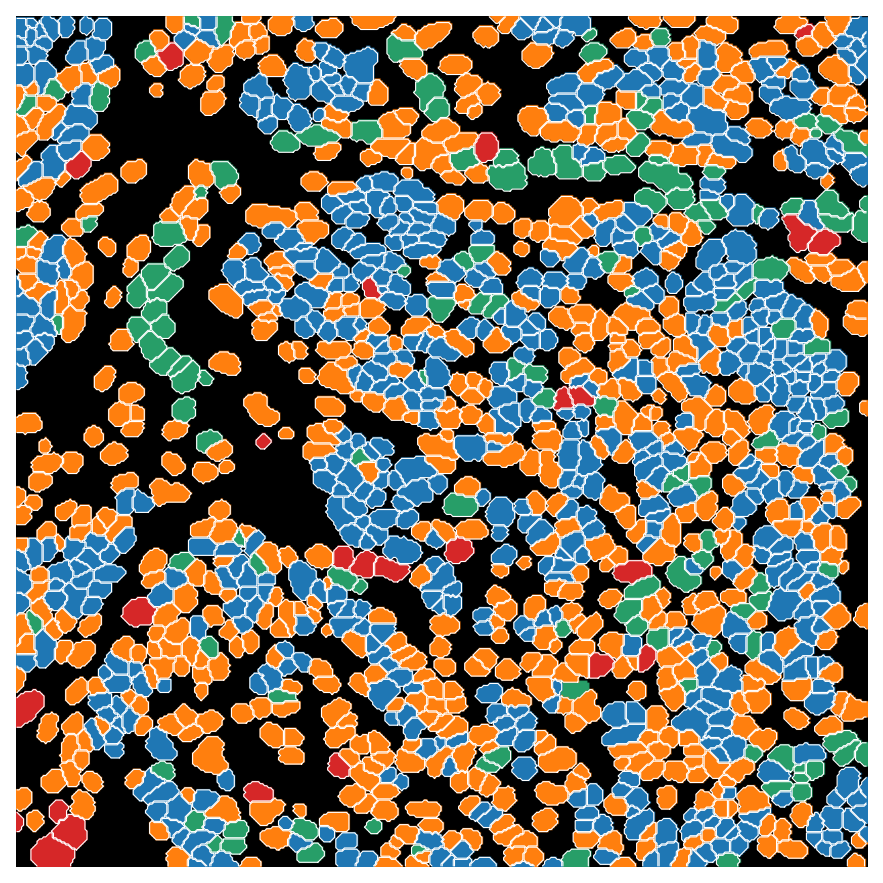

L128_3


  0%|          | 0/4 [00:00<?, ?it/s]

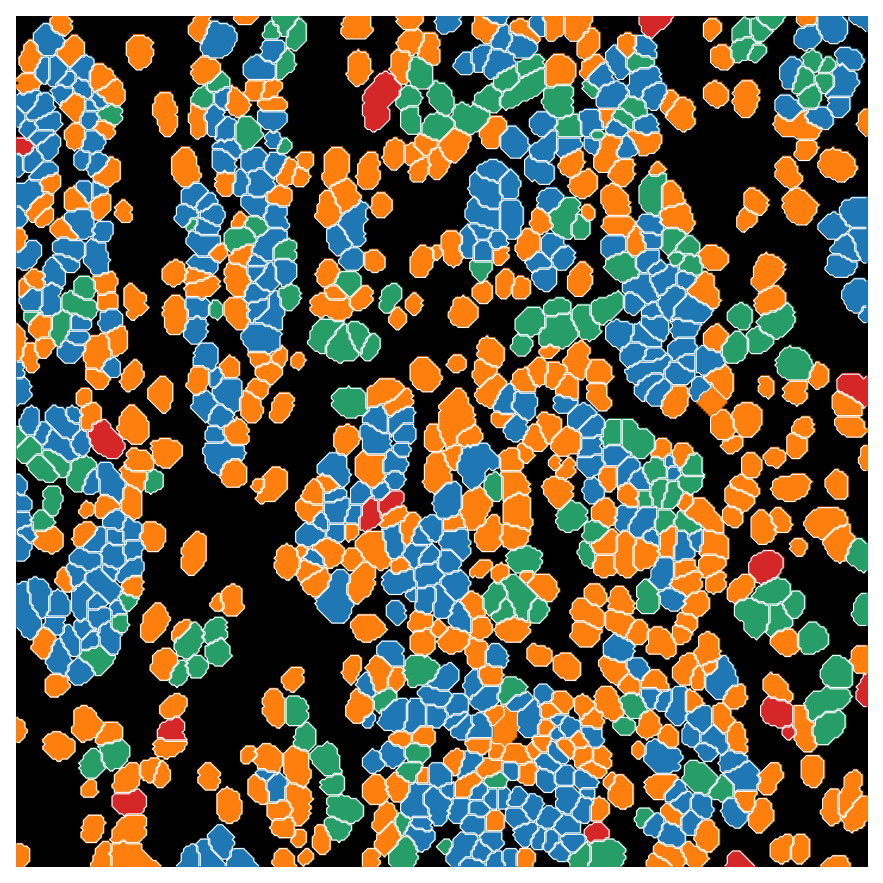

In [283]:
for dataset in datasets:
    print(dataset)
    adata_subset = adata_IMC[adata_IMC.obs.Core == dataset, :]
    try:
        mask = masks["_".join([experiment, dataset])]
        contours = get_contour(mask)
    except:
        continue

    # Get label2cell dict
    label2cell = {}
    for l in labels:
        cell_id = adata_subset[adata_subset.obs.leiden == l].obs.Cell.to_list()
        label2cell[l] = cell_id

    img = create_clustered_cell(mask, label2cell, colors_rgb)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img)
    for j, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color="white")
    ax.axis("off")
    plt.show()

In [284]:
path = data_dir / "adata" / f"{experiment}.h5ad"
adata_IMC.write(path)
